# Introduction to SNPE

<br/>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
sys.path.append("../")
from common import MultivariateGaussianMDN, mog_log_prob, mog_sample

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import pi
from torch.utils import data
import numpy as np
from torch import tensor, ones, zeros, eye
from scipy.signal import argrelextrema
from sbi.utils import pairplot
_ = torch.manual_seed(0)

In [6]:
from numpy import *
from scipy import integrate

### Define a simulator: Lotka-Volterra
Code taken from: https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html

du/dt = au - buv  
dv/dt = -cv + dbu*v

In [7]:
t = linspace(0, 15,  1000)      # time
X0 = array([10, 5])             # initials conditions: 10 rabbits and 5 foxes

In [8]:
def run_model(theta):
    a = theta[0]
    b = theta[1]
    c = 1.5 # theta[2]
    d = 0.75  # theta[3]
    def dX_dt(X, t=0):
        return array([ a*X[0] -   b*X[0]*X[1] ,
                      -c*X[1] + d*b*X[0]*X[1] ])

    X, _ = integrate.odeint(dX_dt, X0, t, full_output=True)
    return X

In [9]:
X = run_model([1.0, 0.1])

Text(0.5, 1.0, 'Evolution of fox and rabbit populations')

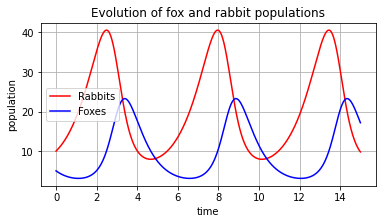

In [10]:
rabbits, foxes = X.T
f1 = plt.subplots(1, 1, figsize=(6, 3))
plt.plot(t, rabbits, 'r-', label='Rabbits')
plt.plot(t, foxes  , 'b-', label='Foxes')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of fox and rabbit populations')

# Summary statistics

In principle, we can run SNPE on the raw trace (more on that later). However, it is often preferable to define summary statistics that are of interest and try reproducing only those.

In [11]:
def summary_stats(trace):

    # for local maxima
    rabbits_maxima_times = argrelextrema(trace[:, 0], np.greater)[0]
    foxes_maxima_times = argrelextrema(trace[:, 1], np.greater)[0]
    
    rabbits_times_diffs = np.mean(np.diff(rabbits_maxima_times))
    foxes_times_diffs = np.mean(np.diff(foxes_maxima_times))
    
    rabbits_maxima_values = trace[:, 0][rabbits_maxima_times]
    foxes_maxima_values = trace[:, 1][foxes_maxima_times]
    
    rabbits_av_max_val = np.mean(rabbits_maxima_values)
    foxes_av_max_val = np.mean(foxes_maxima_values)
    
    return np.asarray([np.mean([rabbits_times_diffs, foxes_times_diffs]), rabbits_av_max_val, foxes_av_max_val])

In [12]:
def new_summstats(trace):
#     original = summary_stats(trace)
    new1 = [np.mean(trace[:, 0])]
    new2 = [np.mean(trace[:, 1])]
    new3 = [np.var(trace[:, 0])]
    new4 = [np.var(trace[:, 1])]
    new5 = [np.correlate(trace[:, 0], trace[:, 0], "full")[100]]
    new6 = [np.correlate(trace[:, 0], trace[:, 0], "full")[200]]
    new7 = [np.correlate(trace[:, 1], trace[:, 1], "full")[100]]
    new8 = [np.correlate(trace[:, 1], trace[:, 1], "full")[200]]
    new9 = np.correlate(trace[:, 0], trace[:, 1])
    return np.concatenate([new1, new2, new3, new4, new5, new6, new7, new8, new9])

In [13]:
def simulate(theta):
    trace = run_model(theta)
    summ_stats = new_summstats(trace)
    return summ_stats

### Define a prior

In [14]:
from sbi.utils import BoxUniform

N = 500

l = 0.1
u = 3.0
lower_bound = [l, l]
upper_bound = [u, u]
prior = BoxUniform(lower_bound, upper_bound)

### Generate simulated data

In [15]:
thetas = prior.sample((N,))
xs = []
for theta in thetas:
    xs.append(simulate(theta))
xs = np.stack(xs)

In [16]:
xs_mean = np.nanmean(xs, axis=0)
xs_std = np.nanstd(xs, axis=0)

xs_zscored = (xs - xs_mean) / xs_std

theta_mean = torch.mean(thetas, dim=0)
theta_std = torch.std(theta, dim=0)
theta_zscored = (thetas - theta_mean) / theta_std

In [17]:
contains_no_nan = np.invert(np.any(np.isnan(xs_zscored), axis=1))
thetas_train = theta_zscored[contains_no_nan]
xs_train = xs_zscored[contains_no_nan]

xs_torch = torch.as_tensor(xs_train, dtype=torch.float32)

# Exercise 1: Train neural network to learn $p(\theta | x)$

In [21]:
dataset = data.TensorDataset(thetas_train, xs_torch)
train_loader = data.DataLoader(
    dataset, batch_size=50,
)
mdn = MultivariateGaussianMDN(
    features=2,
    hidden_net=nn.Sequential(
        nn.Linear(9, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
    ),
    num_components=1,
    hidden_features=10,
)

opt = optim.Adam(mdn.parameters(), lr=0.001)
for e in range(500):
    for theta_batch, x_batch in train_loader:
        opt.zero_grad()
        logits, means, variances = mdn.get_mixture_components(x_batch)
        out = mog_log_prob(theta_batch, logits, means, variances)
        loss = -out.sum()
        loss.backward()
        opt.step()

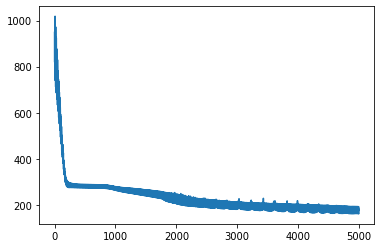

In [22]:
plt.plot(losses)

### Define an observation

In [100]:
gt = [1.0, 0.3]
xo = simulate(gt)

xo_zscored = (xo - xs_mean) / xs_std
xo_torch = torch.as_tensor([xo_zscored], dtype=torch.float32)

### Draw samples from posterior

In [101]:
n = 500

logits, means, variances = mdn.get_mixture_components(xo_torch)

samples = []
for _ in range(n):
    samples.append(mog_sample(logits, means, variances))

In [102]:
samples = torch.cat(samples).detach()
samples = samples * theta_std + theta_mean

/home/michael/Documents/sbi/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(


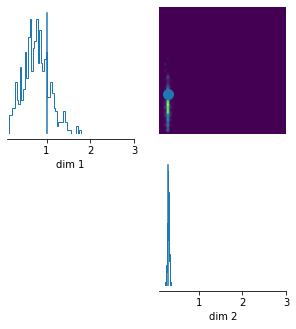

In [103]:
_ = pairplot(samples, limits=np.asarray([lower_bound, upper_bound]).T, points=[gt], figsize=(5, 5))

### Posterior predictive checks

In [104]:
gt_simulation = run_model(gt)
rabbits, foxes = gt_simulation.T

posterior_simulation = run_model(samples[0])
rabbits, foxes = posterior_simulation.T

Text(0.5, 1.0, 'Posterior sample')

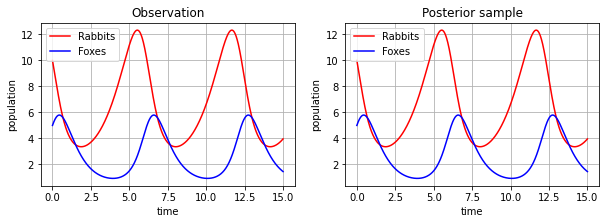

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(t, rabbits, 'r-', label='Rabbits')
ax[0].plot(t, foxes  , 'b-', label='Foxes')
ax[0].grid()
ax[0].legend(loc='best')
ax[0].set_xlabel('time')
ax[0].set_ylabel('population')
ax[0].set_title("Observation")

ax[1].plot(t, rabbits, 'r-', label='Rabbits')
ax[1].plot(t, foxes  , 'b-', label='Foxes')
ax[1].grid()
ax[1].legend(loc='best')
ax[1].set_xlabel('time')
ax[1].set_ylabel('population')
ax[1].set_title("Posterior sample")

# Exercise 2: Test amortization for a few different xo

### Amortization

In [106]:
gt2 = [2.0, 1.3]
xo2 = simulate(gt2)

xo_zscored2 = (xo2 - xs_mean) / xs_std
xo_torch2 = torch.as_tensor([xo_zscored2], dtype=torch.float32)

In [107]:
logits, means, variances = mdn.get_mixture_components(xo_torch2)

samples = []
for _ in range(n):
    samples.append(mog_sample(logits, means, variances)) 

samples = torch.cat(samples).detach()

In [108]:
samples = samples * theta_std + theta_mean

/home/michael/Documents/sbi/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(


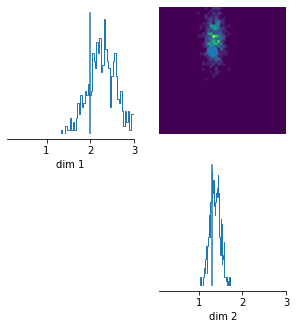

In [109]:
_ = pairplot(samples, limits=np.asarray([lower_bound, upper_bound]).T, points=[gt2], figsize=(5, 5))

In [110]:
gt_simulation = run_model(gt2)
rabbits, foxes = gt_simulation.T

posterior_simulation = run_model(samples[0])
rabbits, foxes = posterior_simulation.T

Text(0.5, 1.0, 'Posterior sample')

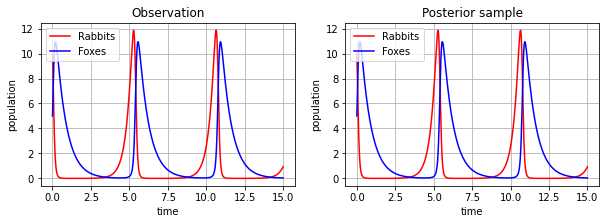

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(t, rabbits, 'r-', label='Rabbits')
ax[0].plot(t, foxes  , 'b-', label='Foxes')
ax[0].grid()
ax[0].legend(loc='best')
ax[0].set_xlabel('time')
ax[0].set_ylabel('population')
ax[0].set_title("Observation")

posterior_simulation = run_model(samples[0])
rabbits, foxes = posterior_simulation.T
ax[1].plot(t, rabbits, 'r-', label='Rabbits')
ax[1].plot(t, foxes  , 'b-', label='Foxes')
ax[1].grid()
ax[1].legend(loc='best')
ax[1].set_xlabel('time')
ax[1].set_ylabel('population')
ax[1].set_title("Posterior sample")

# Embedding network

One can pass the simulated data $x$ through **any** neural network before regressing on the Mixture Parameters (e.g. CNN, LSTM, GNN,...)

### Mixture Density Networks

<img src="../01_density_estimation/figures/architecture.png" alt="drawing" width="600"/>

The loss is now the probability under this mixture of Gaussians  <br/>

$L = -\sum_i \log p(t_i) = -\sum_i \log \sum_j \alpha_{j,i} N(t_i; \mu_{j,i}, \sigma_{j,i})$  <br/>

We learn the mixture components $\alpha_j$, the means $\mu_j$, and the variances $\sigma_j$.

# Example from Neuroscience

At this point, we should maybe add a HH example.

Try to predict membrane conductances (Sodium and Potassium) from observed voltage trace (left). Ground truth in yellow, the prediction of the MDN in red.

<img src="../01_density_estimation/figures/full_HH_fig.png" alt="drawing" width="600"/>

Picture credit to Pedro Gonçalves et al., Cosyne 2017

# Focused (multi-round) inference

Not really sure what to say here yet...